## Imports

In [9]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Embedding, 
    Conv1D, GlobalMaxPooling1D, LSTM,
    Bidirectional, BatchNormalization,
    SimpleRNN
)


colors = mcolors.TABLEAU_COLORS.keys()
dir = '/content/drive/MyDrive/NLP/textClassification2/'

## Data Load

### Mounting google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading and spliting data

In [3]:
# Entire Dataset

train_data = pd.read_csv(
    '/content/drive/MyDrive/NLP/Corona_NLP_train.csv', 
    encoding='latin1'
    )

test_data = pd.read_csv(
    '/content/drive/MyDrive/NLP/Corona_NLP_test.csv', 
    encoding='latin1'
    )

In [ ]:
# Small Dataset with 80-20 split

# data = pd.read_csv(
#     '/content/drive/MyDrive/NLP/Corona_NLP_test.csv',
#      encoding='latin1'
#      )
# train_data = data.sample(frac=0.8, random_state=42)
# test_data = data.drop(train_data.index)

In [4]:
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Training Data Shape: (41157, 6)
Test Data Shape: (3798, 6)


## Data Visualization and Analysis

### About Dataset

#### Coronavirus Tweets

**Dataset:** https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification


This dataset is about **Coronavirus Tweets** and has **sentiments** for each tweet. The tweets have been pulled from Twitter and manual tagging has been done then.

It has the following columns:
1. Location
2. Tweet At
3. Original Tweet
4. Label (Sentiment: ['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative'])

### Model Objective

**Model should be able to predict the sentiment of the tweet by examining it**.

### Distribution of Classes
Below graph shows class distribution

#### Classes Distribution [Training Data]

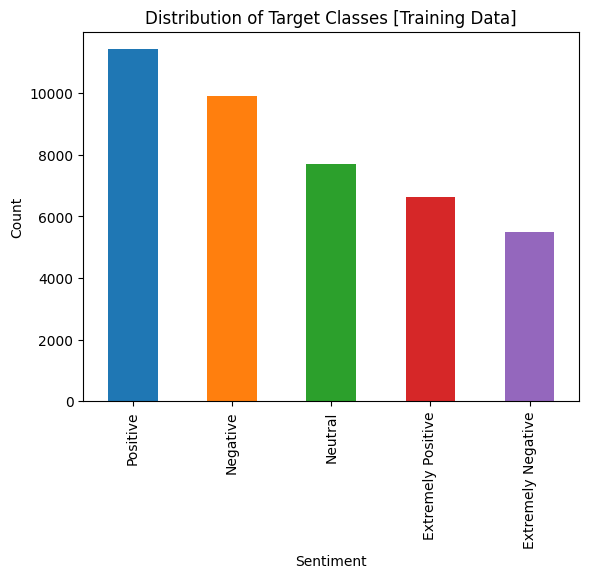

In [20]:

fig = plt.figure()
train_data.value_counts('Sentiment').plot(kind='bar', color=colors)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Distribution of Target Classes [Training Data]')
plt.show()

#### Classes Distribution [Test Data]

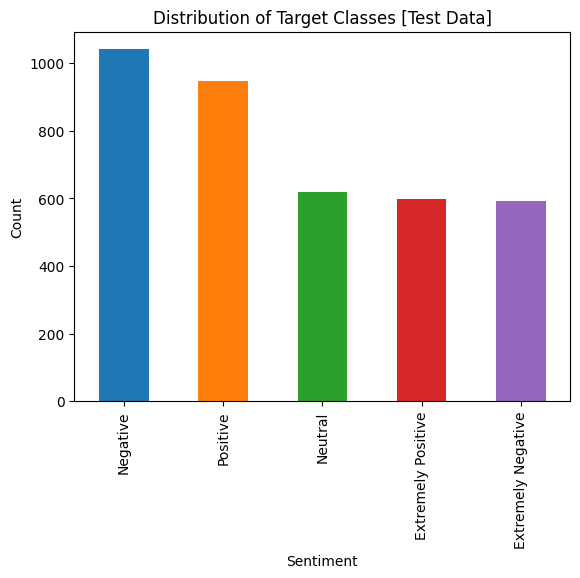

In [19]:
fig = plt.figure()
test_data.value_counts('Sentiment').plot(kind='bar', color=colors)
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Distribution of Target Classes [Test Data]')
plt.show()

#### Classes Distribution in percentage [Training Data]

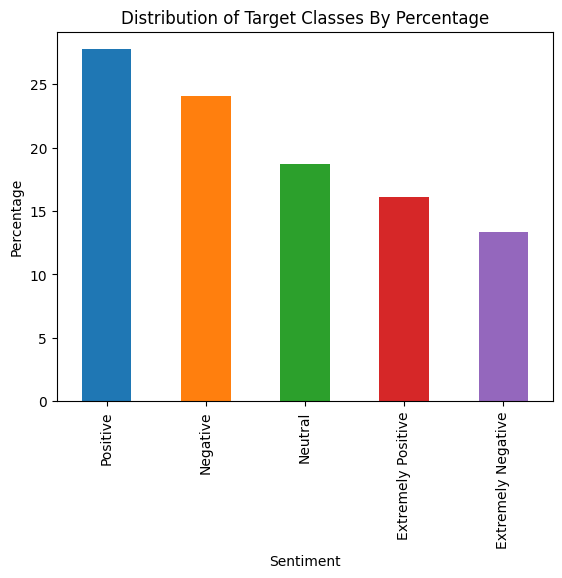

In [5]:
perct_df = (
    train_data.groupby('Sentiment')
    .size().sort_values(ascending=False) / 
    train_data.groupby('Sentiment')
    .size().sort_values(ascending=False).sum()
    )*100
    
fig = plt.figure()
perct_df.plot(kind='bar', color=colors)
plt.ylabel('Percentage')
plt.xlabel('Sentiment')
plt.title('Distribution of Target Classes By Percentage [Training Data]')
plt.show()

#### Classes Distribution in percentage [Test Data]

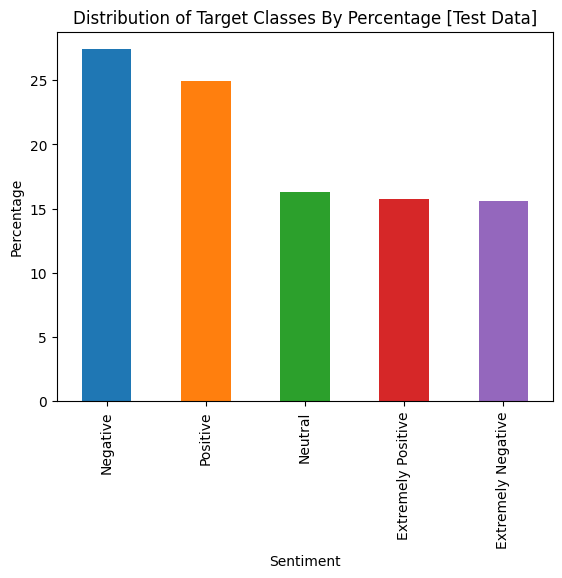

In [18]:
perct_df = (
    test_data.groupby('Sentiment')
    .size().sort_values(ascending=False) / 
    test_data.groupby('Sentiment')
    .size().sort_values(ascending=False).sum()
    )*100
    
fig = plt.figure()
perct_df.plot(kind='bar', color=colors)
plt.ylabel('Percentage')
plt.xlabel('Sentiment')
plt.title('Distribution of Target Classes By Percentage [Test Data]')
plt.show()

## Preprocessing


#### Dropping unwanted columns

In [ ]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [ ]:
train_data.drop(
    ['UserName', 'ScreenName','Location', 'TweetAt' ],
     axis=1, inplace=True
     )
test_data.drop(
    ['UserName', 'ScreenName','Location', 'TweetAt' ], 
    axis=1, inplace=True
    )
train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### Converting Sentiments to numeric values

In [ ]:

encoding = {
    'Positive':0, 'Negative':1, 'Neutral':2, 
    'Extremely Positive':3, 'Extremely Negative':4
    }
train_data = train_data.replace({'Sentiment':encoding})
test_data = test_data.replace({'Sentiment':encoding})

train_labels = train_data['Sentiment']
test_labels = test_data['Sentiment']

print(train_data.Sentiment.value_counts())

train_data.head()

0    11422
1     9917
2     7713
3     6624
4     5481
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",4


## Models

### Model Utils

In [ ]:
# Tokenize the tweets
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_data['OriginalTweet'])
train_sequences = tokenizer.texts_to_sequences(
    train_data['OriginalTweet'])
test_sequences = tokenizer.texts_to_sequences(
    test_data['OriginalTweet'])

In [ ]:
vocab_size = len(tokenizer.word_index)
# vocab_size = len(train_sequences)
vocab_size

85198

In [ ]:
embedding_dim = min(16, round(vocab_size ** 0.25))
print("Recommended embedding dimension:", embedding_dim)

# embedding_dim = 16

Recommended embedding dimension: 16


In [ ]:
num_classes = len(train_data['Sentiment'].unique())
num_classes

5

In [ ]:
maxlen = max(len(x_tr_sqe) for x_tr_sqe in train_sequences)
maxlen

64

In [ ]:
# Pad the sequences
train_padded = pad_sequences(
    train_sequences, padding='post', maxlen=maxlen)
test_padded = pad_sequences(
    test_sequences, padding='post', maxlen=maxlen)

In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=4,
    restore_best_weights=True,
)

### Sequential

In [ ]:
# Define the model
model_seq = Sequential()
model_seq.add(
    Embedding(
        vocab_size, embedding_dim, input_length=maxlen
        ))
model_seq.add(Flatten())
model_seq.add(Dense(16, activation='relu'))
model_seq.add(Dense(num_classes, activation='softmax'))

model_seq.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

# Train the model
history_seq = model_seq.fit(
    train_padded, train_labels, 
    callbacks=[early_stopping], epochs=10, 
    batch_size=32, validation_split=0.2
    )

Epoch 1/10
1029/1029 [==============================] - 25s 23ms/step - loss: 1.4144 - accuracy: 0.3622 - val_loss: 1.1434 - val_accuracy: 0.5259
Epoch 2/10
1029/1029 [==============================] - 25s 24ms/step - loss: 0.9268 - accuracy: 0.6469 - val_loss: 0.9009 - val_accuracy: 0.6491
Epoch 3/10
1029/1029 [==============================] - 24s 23ms/step - loss: 0.6900 - accuracy: 0.7624 - val_loss: 0.8983 - val_accuracy: 0.6488
Epoch 4/10
1029/1029 [==============================] - 25s 24ms/step - loss: 0.5331 - accuracy: 0.8266 - val_loss: 0.9655 - val_accuracy: 0.6301
Epoch 5/10
1029/1029 [==============================] - 22s 21ms/step - loss: 0.3988 - accuracy: 0.8736 - val_loss: 1.0962 - val_accuracy: 0.6212
Epoch 6/10
1029/1029 [==============================] - 25s 24ms/step - loss: 0.2870 - accuracy: 0.9181 - val_loss: 1.2846 - val_accuracy: 0.6033
Epoch 7/10
1029/1029 [==============================] - 26s 25ms/step - loss: 0.1988 - accuracy: 0.9484 - val_loss: 1.4747 -

In [ ]:
# Evaluate the model
loss_seq, accuracy_seq = model_seq.evaluate(
    test_padded, test_labels)
print(f'Test Accuracy with Sequential: {accuracy_seq}')
print(f'Test Loss with Sequential: {loss_seq}')

119/119 [==============================] - 0s 2ms/step - loss: 0.9686 - accuracy: 0.6327
Test Accuracy with Sequential: 0.6327013969421387
Test Loss with Sequential: 0.9686248898506165


<Axes: >

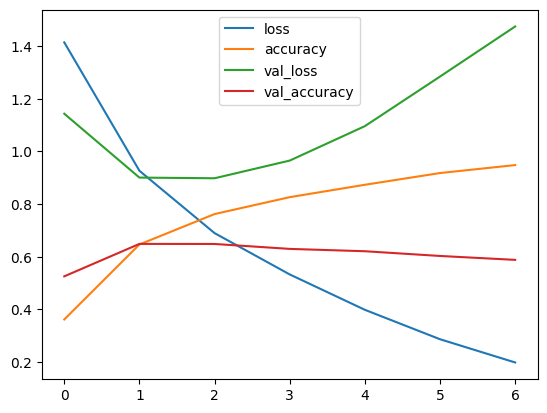

In [ ]:
pd.DataFrame(history_seq.history).plot()

In [ ]:
# Save and delete the model and history
model_seq.save(dir+'model_seq') 
del model_seq

with open(dir+'history_seq', 'wb') as file_pi:
    pickle.dump(history_seq, file_pi)
del history_seq

### CNN

In [ ]:
filters = 128
kernel_size = 5

# Define the CNN model
model_cnn = Sequential()
model_cnn.add(
    Embedding(vocab_size , embedding_dim))
model_cnn.add(
    Conv1D(filters , kernel_size , activation = 'relu'
    ))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(512 , activation = 'relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(num_classes , activation = 'softmax'))

# Compile the model
model_cnn.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])


# Train the model
history_cnn = model_cnn.fit(
    train_padded, train_labels, 
    callbacks=[early_stopping], epochs=10, 
    batch_size=32, validation_split=0.2)

Epoch 1/10
1029/1029 [==============================] - 32s 31ms/step - loss: 1.1594 - accuracy: 0.5127 - val_loss: 0.8274 - val_accuracy: 0.6917
Epoch 2/10
1029/1029 [==============================] - 30s 30ms/step - loss: 0.7746 - accuracy: 0.7082 - val_loss: 0.7968 - val_accuracy: 0.7068
Epoch 3/10
1029/1029 [==============================] - 30s 29ms/step - loss: 0.6449 - accuracy: 0.7671 - val_loss: 0.7827 - val_accuracy: 0.7165
Epoch 4/10
1029/1029 [==============================] - 30s 29ms/step - loss: 0.5333 - accuracy: 0.8128 - val_loss: 0.8395 - val_accuracy: 0.7046
Epoch 5/10
1029/1029 [==============================] - 30s 29ms/step - loss: 0.4329 - accuracy: 0.8499 - val_loss: 0.9012 - val_accuracy: 0.7026
Epoch 6/10
1029/1029 [==============================] - 31s 30ms/step - loss: 0.3411 - accuracy: 0.8837 - val_loss: 1.0391 - val_accuracy: 0.6957
Epoch 7/10
1029/1029 [==============================] - 31s 30ms/step - loss: 0.2730 - accuracy: 0.9080 - val_loss: 1.2803 -

In [ ]:
# Evaluate the model
loss_cnn, accuracy_cnn = model_cnn.evaluate(
    test_padded, test_labels)
print(f'Test Accuracy with CNN: {accuracy_cnn}')
print(f'Test Loss with CNN: {loss_cnn}')

119/119 [==============================] - 0s 3ms/step - loss: 0.8610 - accuracy: 0.6751
Test Accuracy with CNN: 0.6750921607017517
Test Loss with CNN: 0.8609734177589417


<Axes: >

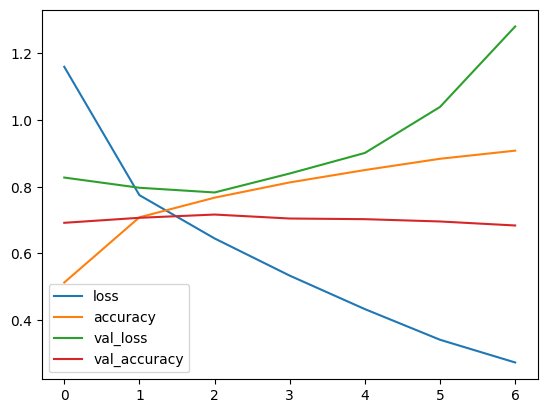

In [ ]:
pd.DataFrame(history_cnn.history).plot()

In [ ]:
# Save and delete the model and history
model_cnn.save(dir+'model_cnn') 
del model_cnn

with open(dir+'history_cnn', 'wb') as file_pi:
    pickle.dump(history_cnn, file_pi)
del history_cnn

### Simple RNN

In [ ]:
# Define the RNN model
model_rnn = Sequential()
model_rnn.add(
    Embedding(vocab_size, embedding_dim, 
              input_length=maxlen))
model_rnn.add(
    Bidirectional(SimpleRNN(32 , return_sequences = True)))
model_rnn.add(BatchNormalization())
model_rnn.add(Bidirectional(SimpleRNN(64)))
model_rnn.add(BatchNormalization())
model_rnn.add(Dense(512 , activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(5 , activation = 'softmax'))

# Compile the model
model_rnn.compile(
    optimizer='adam', loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(
    train_padded, train_labels, 
    epochs=10, batch_size=32, 
    validation_split=0.2)


Epoch 1/10
1029/1029 [==============================] - 113s 104ms/step - loss: 1.5177 - accuracy: 0.3085 - val_loss: 6.0060 - val_accuracy: 0.1760
Epoch 2/10
1029/1029 [==============================] - 102s 100ms/step - loss: 1.1001 - accuracy: 0.5389 - val_loss: 1.2750 - val_accuracy: 0.5193
Epoch 3/10
1029/1029 [==============================] - 104s 101ms/step - loss: 0.8624 - accuracy: 0.6672 - val_loss: 0.9227 - val_accuracy: 0.6063
Epoch 4/10
1029/1029 [==============================] - 105s 102ms/step - loss: 0.7748 - accuracy: 0.7088 - val_loss: 1.0803 - val_accuracy: 0.5652
Epoch 5/10
1029/1029 [==============================] - 101s 98ms/step - loss: 0.7151 - accuracy: 0.7367 - val_loss: 1.2673 - val_accuracy: 0.6249
Epoch 6/10
1029/1029 [==============================] - 102s 99ms/step - loss: 0.6473 - accuracy: 0.7624 - val_loss: 2.5111 - val_accuracy: 0.4738
Epoch 7/10
1029/1029 [==============================] - 100s 97ms/step - loss: 0.6147 - accuracy: 0.7749 - val_los

In [ ]:
# Evaluate the model
loss_rnn, accuracy_rnn = model_rnn.evaluate(
    test_padded, test_labels)
print(f'Test Accuracy with Simple RNN: {accuracy_rnn}')
print(f'Test Loss with Simple RNN: {loss_rnn}')

119/119 [==============================] - 2s 16ms/step - loss: 2.8046 - accuracy: 0.5590
Test Accuracy with Simple RNN: 0.5589784383773804
Test Loss with Simple RNN: 2.804551839828491


<Axes: >

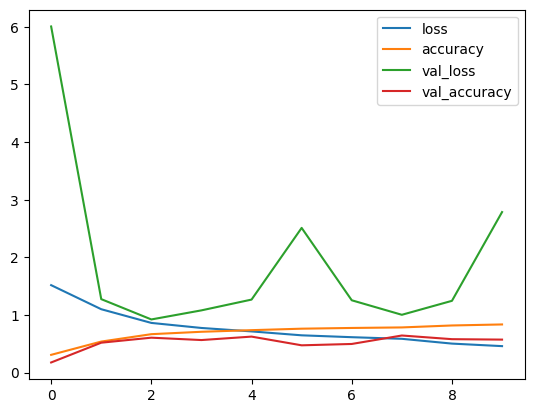

In [ ]:
pd.DataFrame(history_rnn.history).plot()

In [ ]:
# Save and delete the model and history
model_rnn.save(dir+'model_rnn') 
del model_rnn

with open(dir+'history_rnn', 'wb') as file_pi:
    pickle.dump(history_rnn, file_pi)
del history_rnn

### LSTM

In [ ]:
# Define the model
model_lstm = Sequential()
model_lstm.add(
    Embedding(vocab_size, embedding_dim, 
              input_length=maxlen))
model_lstm.add(
    Bidirectional(LSTM(32 , return_sequences = True)))
model_lstm.add(BatchNormalization())
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(BatchNormalization())
model_lstm.add(Dense(512 , activation = 'relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(num_classes , activation = 'softmax'))

model_lstm.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model
history_lstm = model_lstm.fit(
    train_padded, train_labels,
    callbacks=[early_stopping], 
    epochs=10, batch_size=32, 
    validation_split=0.2)


Epoch 1/10
1029/1029 [==============================] - 204s 188ms/step - loss: 1.1492 - accuracy: 0.5121 - val_loss: 1.5284 - val_accuracy: 0.4410
Epoch 2/10
1029/1029 [==============================] - 202s 196ms/step - loss: 0.7783 - accuracy: 0.7118 - val_loss: 0.8272 - val_accuracy: 0.7195
Epoch 3/10
1029/1029 [==============================] - 186s 181ms/step - loss: 0.6656 - accuracy: 0.7604 - val_loss: 0.7744 - val_accuracy: 0.7059
Epoch 4/10
1029/1029 [==============================] - 189s 184ms/step - loss: 0.5801 - accuracy: 0.7958 - val_loss: 0.9326 - val_accuracy: 0.6715
Epoch 5/10
1029/1029 [==============================] - 201s 196ms/step - loss: 0.5003 - accuracy: 0.8243 - val_loss: 1.1208 - val_accuracy: 0.6426
Epoch 6/10
1029/1029 [==============================] - 204s 198ms/step - loss: 0.4295 - accuracy: 0.8496 - val_loss: 0.8748 - val_accuracy: 0.7253
Epoch 7/10
1029/1029 [==============================] - 201s 196ms/step - loss: 0.3666 - accuracy: 0.8728 - val_

In [ ]:
# Evaluate the model
loss_lstm, accuracy_lstm = model_lstm.evaluate(
    test_padded, test_labels)
print(f'Test Accuracy with LSTM: {accuracy_lstm}')
print(f'Test Loss with LSTM: {loss_lstm}')

119/119 [==============================] - 4s 33ms/step - loss: 0.8378 - accuracy: 0.6830
Test Accuracy with LSTM: 0.6829910278320312
Test Loss with LSTM: 0.837775468826294


<Axes: >

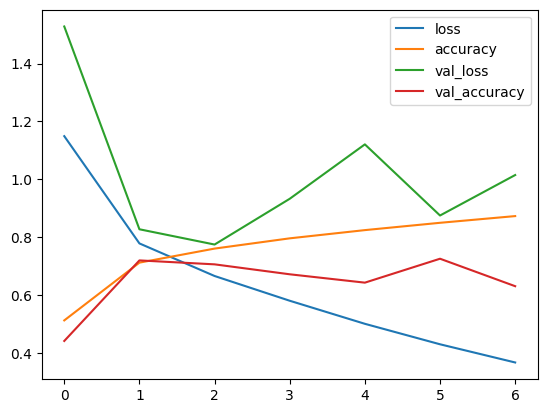

In [ ]:
pd.DataFrame(history_lstm.history).plot()

In [ ]:
# Save and delete the model and history
model_lstm.save(dir+'model_lstm') 
del model_lstm

with open(dir+'history_lstm', 'wb') as file_pi:
    pickle.dump(history_lstm, file_pi)
del history_lstm

### Pretrained LSTM - Pretrained Word Embeddings

In [ ]:
# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-04-20 06:54:55--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-20 06:54:55--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-20 06:54:55--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
# Load the pre-trained embeddings into a dictionary
embeddings_index = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Create an embedding matrix for the words in the training data
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Define the model with pre-trained embeddings
model_pretrained = Sequential()
model_pretrained.add(
    Embedding(
        vocab_size, embedding_dim, 
        input_length=maxlen, 
        weights=[embedding_matrix], 
        trainable=False))
model_pretrained.add(
    Bidirectional(LSTM(32 , return_sequences = True)))
model_pretrained.add(BatchNormalization())
model_pretrained.add(Bidirectional(LSTM(64)))
model_pretrained.add(BatchNormalization())
model_pretrained.add(Dense(512 , activation = 'relu'))
model_pretrained.add(Dropout(0.2))
model_pretrained.add(
    Dense(num_classes , activation = 'softmax'))

# Compile the model
model_pretrained.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

# Train the model
history_pretrained = model_pretrained.fit(
    train_padded, train_labels, 
    callbacks=[early_stopping], 
    epochs=10, batch_size=32, 
    validation_split=0.2)

Epoch 1/10
1029/1029 [==============================] - 214s 197ms/step - loss: 1.2831 - accuracy: 0.4415 - val_loss: 1.2080 - val_accuracy: 0.5001
Epoch 2/10
1029/1029 [==============================] - 189s 183ms/step - loss: 1.0389 - accuracy: 0.5771 - val_loss: 0.9378 - val_accuracy: 0.6328
Epoch 3/10
1029/1029 [==============================] - 188s 183ms/step - loss: 0.8872 - accuracy: 0.6616 - val_loss: 0.8477 - val_accuracy: 0.6936
Epoch 4/10
1029/1029 [==============================] - 196s 190ms/step - loss: 0.8013 - accuracy: 0.7034 - val_loss: 0.8249 - val_accuracy: 0.6941
Epoch 5/10
1029/1029 [==============================] - 186s 181ms/step - loss: 0.7358 - accuracy: 0.7346 - val_loss: 0.7768 - val_accuracy: 0.7194
Epoch 6/10
1029/1029 [==============================] - 202s 196ms/step - loss: 0.6900 - accuracy: 0.7490 - val_loss: 0.8023 - val_accuracy: 0.7308
Epoch 7/10
1029/1029 [==============================] - 199s 193ms/step - loss: 0.6428 - accuracy: 0.7679 - val_

In [ ]:
# Evaluate the model
loss_pretrained, accuracy_pretrained = model_pretrained.evaluate(
    test_padded, test_labels)
print(
    f'Test Accuracy with LSTM Pretrained: {accuracy_pretrained}'
    )
print(
    f'Test Loss with LSTM Pretrained: {loss_pretrained}'
    )

119/119 [==============================] - 7s 59ms/step - loss: 0.8615 - accuracy: 0.6804
Test Accuracy with LSTM Pretrained: 0.6803581118583679
Test Loss with LSTM Pretrained: 0.8615074753761292


<Axes: >

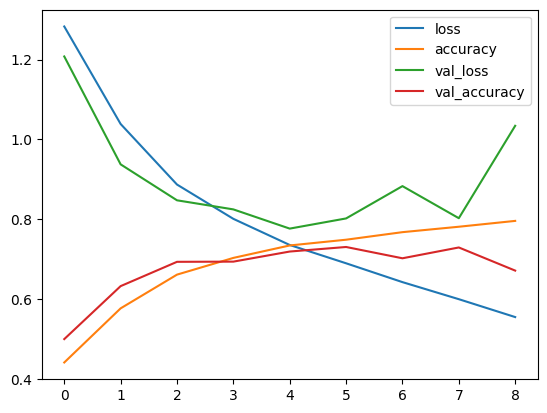

In [ ]:
pd.DataFrame(history_pretrained.history).plot()

In [ ]:
# Save and delete the model and history
model_pretrained.save(dir+'model_pretrained') 
del model_pretrained

with open(dir+'history_pretrained', 'wb') as file_pi:
    pickle.dump(history_pretrained, file_pi)
del history_pretrained

### Character Embeddings

In [40]:
# Convert text to lowercase
train_text = train_data["OriginalTweet"].str.lower()
test_text = test_data["OriginalTweet"].str.lower()

# Convert text to sequences of character indices
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_text)
train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)

# Pad sequences to a fixed length
# maxlen = 140  # Example sequence length
train_seq = pad_sequences(train_seq, maxlen=maxlen)
test_seq = pad_sequences(test_seq, maxlen=maxlen)

# Define the model architecture
model_char = Sequential()
model_char.add(
    Embedding(
        input_dim=len(tokenizer.word_index)+1, 
        output_dim=100, input_length=maxlen))
model_char.add(
    Bidirectional(LSTM(32 , return_sequences = True)))
model_char.add(BatchNormalization())
model_char.add(Bidirectional(LSTM(64)))
model_char.add(BatchNormalization())
model_char.add(Dense(512 , activation = 'relu'))
model_char.add(Dropout(0.2))
model_char.add(
    Dense(num_classes , activation = 'softmax'))

# Compile the model
optimizer = Adam(learning_rate=1e-4)
model_char.compile(
    loss='categorical_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy'])

# Train the model
y_train = pd.get_dummies(
    train_data["Sentiment"]).values
y_test = pd.get_dummies(
    test_data["Sentiment"]).values
history_char = model_char.fit(
    train_seq, y_train, 
    validation_data=(test_seq, y_test), 
    callbacks=[early_stopping], 
    epochs=10, batch_size=32)

Epoch 1/10
1287/1287 [==============================] - 267s 198ms/step - loss: 1.6165 - accuracy: 0.2587 - val_loss: 1.5903 - val_accuracy: 0.2662
Epoch 2/10
1287/1287 [==============================] - 249s 194ms/step - loss: 1.5773 - accuracy: 0.2770 - val_loss: 1.5833 - val_accuracy: 0.2641
Epoch 3/10
1287/1287 [==============================] - 247s 192ms/step - loss: 1.5615 - accuracy: 0.2871 - val_loss: 1.5848 - val_accuracy: 0.2641
Epoch 4/10
1287/1287 [==============================] - 249s 194ms/step - loss: 1.5480 - accuracy: 0.2953 - val_loss: 1.5814 - val_accuracy: 0.2746
Epoch 5/10
1287/1287 [==============================] - 242s 188ms/step - loss: 1.5363 - accuracy: 0.2999 - val_loss: 1.5765 - val_accuracy: 0.2694
Epoch 6/10
1287/1287 [==============================] - 250s 195ms/step - loss: 1.5280 - accuracy: 0.3091 - val_loss: 1.5808 - val_accuracy: 0.2678
Epoch 7/10
1287/1287 [==============================] - 248s 193ms/step - loss: 1.5183 - accuracy: 0.3170 - val_

In [41]:
# Evaluate the model
loss_char, accuracy_char = model_char.evaluate(
    test_seq, y_test, verbose=0)
print(
    f'Test Accuracy with Char Embeddings: {accuracy_char}')
print(
    f'Test Loss with Char Embeddings: {loss_char}')

Test Accuracy with Char Embeddings: 0.2693522870540619
Test Loss with Char Embeddings: 1.5764895677566528


<Axes: >

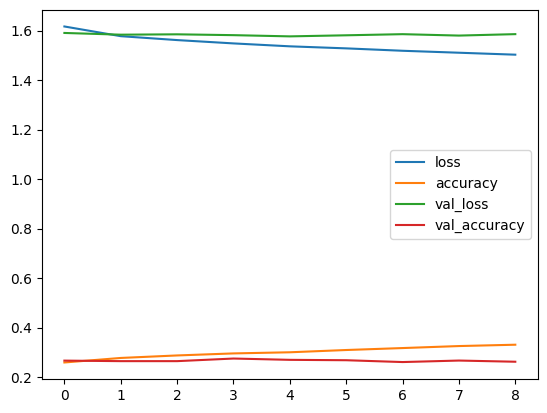

In [42]:
pd.DataFrame(history_char.history).plot()

In [43]:
# Save and delete the model and history
model_char.save(dir+'model_char') 
del model_char

with open(dir+'history_char', 'wb') as file_pi:
    pickle.dump(history_char, file_pi)
del history_char

## Model Comparison

### Load model history

In [47]:
with open(
    dir+'history_seq', 
    "rb"
    ) as f:
    history_seq = pickle.load(f)

with open(
    dir+'history_cnn', 
    "rb"
    ) as f:
    history_cnn = pickle.load(f)

with open(
    dir+'history_rnn', 
    "rb"
    ) as f:
    history_rnn = pickle.load(f)

with open(
    dir+'history_lstm', 
    "rb"
    ) as f:
    history_lstm = pickle.load(f)

with open(
    dir+'history_pretrained', 
    "rb"
    ) as f:
    history_pretrained = pickle.load(f)

with open(
    dir+'history_char', 
    "rb"
    ) as f:
    history_char = pickle.load(f)


### Plot history

Text(0.5, 1.0, 'Char Embeddings')

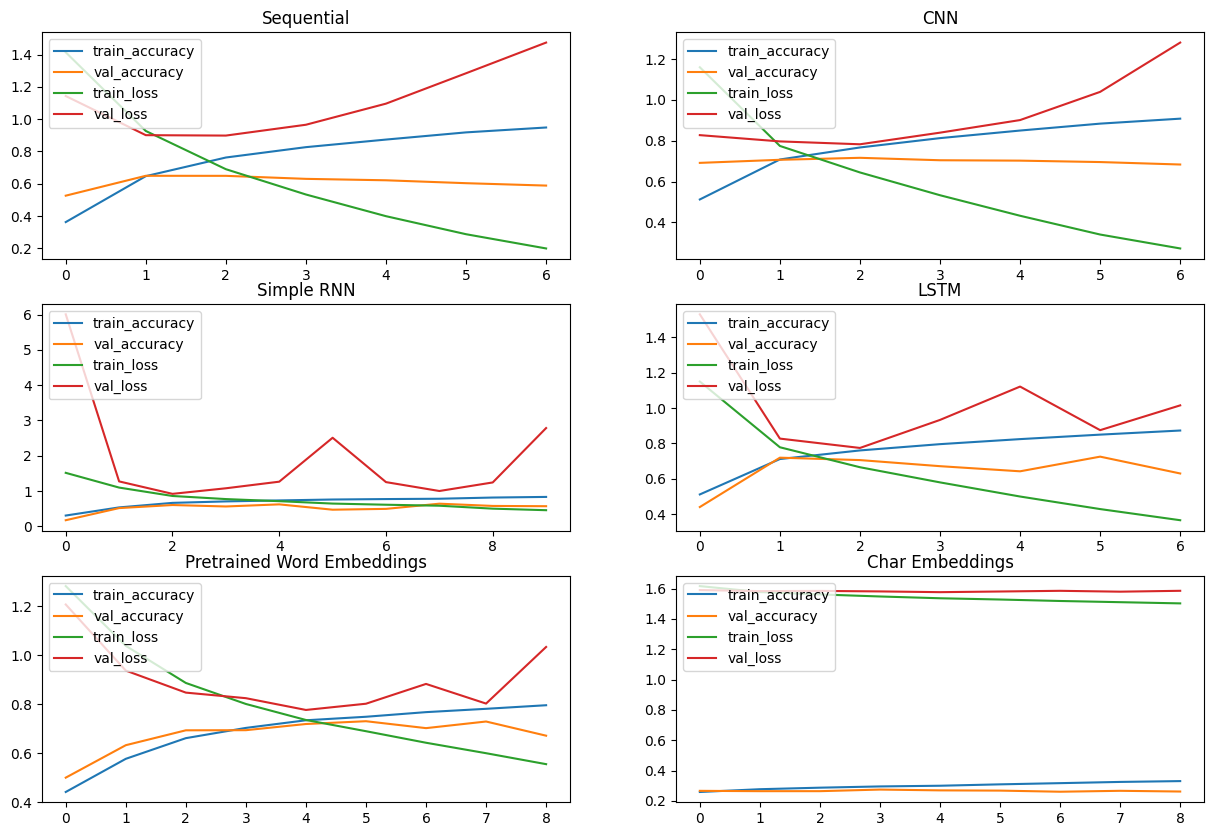

In [49]:
figure, axis = plt.subplots(3, 2,  figsize=(15, 10))

# Sequential
axis[0,0].plot(history_seq.history['accuracy'])
axis[0,0].plot(history_seq.history['val_accuracy'])
axis[0,0].plot(history_seq.history['loss'])
axis[0,0].plot(history_seq.history['val_loss'])
axis[0,0].legend(
    ['train_accuracy', 'val_accuracy', 
    'train_loss', 'val_loss'], loc='upper left')
axis[0,0].set_title("Sequential")

# CNN
axis[0,1].plot(history_cnn.history['accuracy'])
axis[0,1].plot(history_cnn.history['val_accuracy'])
axis[0,1].plot(history_cnn.history['loss'])
axis[0,1].plot(history_cnn.history['val_loss'])
axis[0,1].legend(
    ['train_accuracy', 'val_accuracy',
    'train_loss', 'val_loss'], loc='upper left')
axis[0,1].set_title("CNN")

# Simple RNN
axis[1,0].plot(history_rnn.history['accuracy'])
axis[1,0].plot(history_rnn.history['val_accuracy'])
axis[1,0].plot(history_rnn.history['loss'])
axis[1,0].plot(history_rnn.history['val_loss'])
axis[1,0].legend(
    ['train_accuracy', 'val_accuracy', 
    'train_loss', 'val_loss'], loc='upper left')
axis[1,0].set_title("Simple RNN")

# LSTM
axis[1,1].plot(history_lstm.history['accuracy'])
axis[1,1].plot(history_lstm.history['val_accuracy'])
axis[1,1].plot(history_lstm.history['loss'])
axis[1,1].plot(history_lstm.history['val_loss'])
axis[1,1].legend(
    ['train_accuracy', 'val_accuracy', 
    'train_loss', 'val_loss'], loc='upper left')
axis[1,1].set_title("LSTM")


# Pretrained Word Embeddings
axis[2,0].plot(history_pretrained.history['accuracy'])
axis[2,0].plot(history_pretrained.history['val_accuracy'])
axis[2,0].plot(history_pretrained.history['loss'])
axis[2,0].plot(history_pretrained.history['val_loss'])
axis[2,0].legend(
    ['train_accuracy', 'val_accuracy',
    'train_loss', 'val_loss'], loc='upper left')
axis[2,0].set_title("Pretrained Word Embeddings")

# Char Embeddings
axis[2,1].plot(history_char.history['accuracy'])
axis[2,1].plot(history_char.history['val_accuracy'])
axis[2,1].plot(history_char.history['loss'])
axis[2,1].plot(history_char.history['val_loss'])
axis[2,1].legend(
    ['train_accuracy', 'val_accuracy', 
    'train_loss', 'val_loss'], loc='upper left')
axis[2,1].set_title("Char Embeddings")

## Analysis of the performance of various approaches

## Analysis of the performance of the various approaches:
---

### Simple Sequential Model:
The simple sequential model achieved a test accuracy of around 63%, which is not bad for a simple model. However, the model may not be able to capture complex relationships between words and may suffer from overfitting.

The Sequential Model plot above shows that the training loss continues to decrease while the validation loss continues to increase from epoch 1, this indicates overfitting. The model is optimizing the training data too well and is starting to overfit to noise and outliers in the data.

### CNN Model:
The CNN model achieved a test accuracy of around 67%, which is comparable to the LSTM model. The CNN model uses convolutions to extract local features from the text data, which can be useful for tasks like text classification.

The CNN Model plot above shows that training accuracy continues to increase while the validation accuracy is plateau at 0.7, this indicates overfitting. The model is starting to memorize the training data and is no longer able to generalize well to new data.

### Simple RNN Model:
The Simple RNN model achieved a test accuracy of around 55%, which is less as compared to the CNN and the LSTM models.

### LSTM Model:
The LSTM model performed better than the simple sequential model, achieving a test accuracy of around 68.2%. This is because the LSTM model can capture the sequential nature of text data and remember important information from earlier time steps.

The LSTM Model plot above shows that the training loss continues to decrease but the validation loss increases from epoch 2, this indicates overfitting. The model is optimizing the training data too well and is starting to overfit to noise and outliers in the data.

### Pretrained Word Embeddings LSTM Model:
Using pretrained word embeddings like GloVe improved the performance of the model, achieving a test accuracy of 68%. This is because pre-trained embeddings can capture the semantic meaning of words and improve the model's ability to understand the text data.

The Pretrained Word Embeddings LSTM Model shows the train and validation accuracy increaes and the train and validation loss decreases. So there is no overfitting and the accuracy of the model is best in all the models.

### Character Embeddings:
Using character-level embeddings the model performed poorly, only achieving a test accuracy of 26%. By far the lowest accuracy.

---

## Conslusion:

**The LSTM model with pre-trained GloVe word embeddings is the best performing model** among the ones tested. However, further improvements can be made by experimenting with different hyperparameters, using more advanced architectures like transformers, and incorporating additional features.